# Transfer Learning Segmentation of 7T images

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from tqdm.notebook import tqdm
from pathlib import Path
import pandas as pd

In [3]:
from fastai.callbacks import CSVLogger

In [4]:
torch.cuda.set_device(1)

In [5]:
def acc_seg(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()
def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False)->Rank0Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

In [6]:
dice0inv = partial(multi_dice, class_id=0, inverse=True)
dice1 = partial(multi_dice, class_id=1)
dice2 = partial(multi_dice, class_id=2)
dice0inv.__name__ = 'diceComb'
dice1.__name__ = 'diceLV'
dice2.__name__ = 'diceMY'

In [7]:
get_y_fn = lambda x: str(x).replace("image", "mask")

In [8]:
src = (SegmentationItemList.from_folder("images", presort=True)
       .split_by_folder(train="train", valid="val")
       .label_from_func(get_y_fn, classes=np.array(["background","left_ventricle","myocardium"])))

In [9]:
# tfms = get_transforms(do_flip=False,max_rotate=20,max_lighting=.4,max_zoom=1.2)
# use extreme transforms
tfms = get_transforms(do_flip=True,max_rotate=90,max_lighting=.4,max_zoom=1.2)

In [10]:
data = (src.transform(tfms,size=256,padding_mode="zeros",resize_method=ResizeMethod.PAD,tfm_y=True)
       .add_test_folder("test", tfm_y=False)
       .databunch(bs=8)
       .normalize(imagenet_stats))

In [12]:
data

ImageDataBunch;

Train: LabelList (5076 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: images;

Valid: LabelList (1842 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: images;

Test: LabelList (955 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: images

In [13]:
# All images as testData for full prediction
testData = ImageList.from_folder("images")
testData

ImageList (7873 items)
Image (3, 472, 512),Image (3, 472, 512),Image (3, 512, 472),Image (3, 512, 472),Image (3, 512, 472)
Path: images

In [14]:
def make_full_predictions(modelFile, name):
    learn = load_learner('images',modelFile,test=testData,tfm_y=False)
    preds,_ = learn.get_preds(DatasetType.Test)
    for d in ['preds{}/{}/{}'.format(i,name,j) for i in ['', '_raw'] for j in ['test','val','train']]:
        os.makedirs(d,exist_ok=True)
    for i in tqdm(range(len(preds))):
        p = preds[i]
        file = str(testData.items[i])
        raw_file = file.replace("images","preds_raw/{}".format(name))
        Image(p).save(raw_file)
        pred_file = file.replace("images","preds/{}".format(name))
        PIL.Image.fromarray(np.array(p.argmax(dim=0), dtype=np.int32),'I').save(pred_file)
    return preds

## Plain Learning (random init)

In [18]:
plainLearn = unet_learner(data, models.resnet34, pretrained=False, metrics=[acc_seg,dice0inv,dice1,dice2], callback_fns=[partial(CSVLogger, append=True, filename="plainLearn_log")])

In [19]:
# unfreeze directly, as the weights are random there is no point in freezing them
plainLearn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


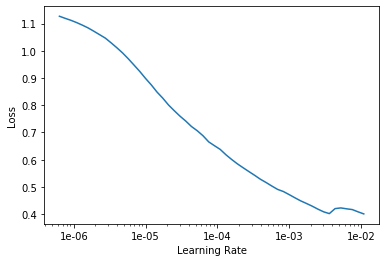

In [20]:
lr_find(plainLearn)
plainLearn.recorder.plot()

In [21]:
lr=1e-4
plainLearn.fit_one_cycle(10,lr)
plainLearn.save('plainLearn-unfrozen-10')

epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.052986,0.045612,0.983289,0.621526,0.574484,0.248142,11:50
1,0.028847,0.029132,0.990065,0.671092,0.682669,0.445890,11:40
2,0.020137,0.016272,0.993833,0.811782,0.811573,0.650918,11:39
3,0.014801,0.013594,0.994984,0.837940,0.846688,0.665616,11:36
4,0.013254,0.014086,0.994595,0.810198,0.793858,0.648907,11:36
5,0.010530,0.011903,0.995219,0.843521,0.841745,0.699564,11:29
6,0.009668,0.010651,0.995664,0.881335,0.873510,0.733801,11:28
7,0.008794,0.009695,0.996147,0.888178,0.880122,0.752406,11:31
8,0.007981,0.010201,0.996008,0.894655,0.886346,0.760592,11:33
9,0.008276,0.010206,0.996070,0.900008,0.891930,0.766380,11:31


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.007731,0.010222,0.996058,0.901971,0.893940,0.769092,11:33
1,0.007986,0.009993,0.996053,0.889209,0.882385,0.756177,11:36
2,0.007750,0.010172,0.996011,0.899675,0.890868,0.766701,11:35
3,0.007635,0.010441,0.996017,0.896895,0.886460,0.762595,11:34
4,0.007324,0.010092,0.996087,0.894563,0.890066,0.763968,11:33
5,0.007063,0.010769,0.996041,0.900462,0.893488,0.765634,11:33
6,0.007675,0.010250,0.996065,0.901288,0.890933,0.770370,11:32
7,0.007096,0.010656,0.996063,0.903339,0.894115,0.769040,11:32
8,0.007046,0.010478,0.996076,0.902391,0.894032,0.769542,11:32
9,0.007371,0.010364,0.996087,0.902404,0.893552,0.769508,11:31


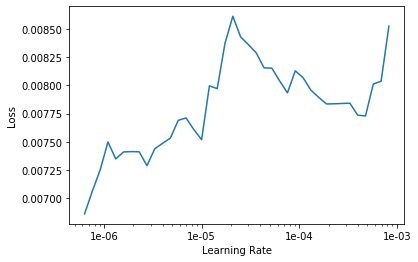

In [22]:
lr_find(plainLearn)
plainLearn.recorder.plot()
lr=1e-5
plainLearn.fit_one_cycle(10,lr)
plainLearn.save('plainLearn-unfrozen-20')

In [23]:
plainLearn.export('plainLearn.pkl',destroy=True)

this Learner object self-destroyed - it still exists, but no longer usable


In [24]:
tmp = make_full_predictions('plainLearn.pkl', 'plainLearn')

## Transfer Learning (imagenet)

In [25]:
imagenetTransferLearn = unet_learner(data, models.resnet34, pretrained=True, metrics=[acc_seg,dice0inv,dice1,dice2], callback_fns=[partial(CSVLogger, append=True, filename="imagenetTransferLearn_log")])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


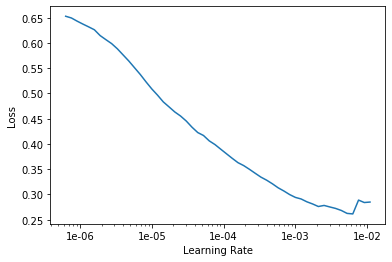

In [26]:
lr_find(imagenetTransferLearn)
imagenetTransferLearn.recorder.plot()

In [27]:
lr=1e-4
imagenetTransferLearn.fit_one_cycle(10,lr)
imagenetTransferLearn.save('imagenetTransferLearn-frozen-10')

epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.023253,0.021871,0.991925,0.744454,0.771940,0.513451,11:07
1,0.014493,0.016748,0.994194,0.805831,0.811239,0.643718,11:05
2,0.010652,0.011413,0.995646,0.869662,0.882719,0.717505,11:04
3,0.009673,0.011414,0.995830,0.881875,0.885309,0.745215,11:02
4,0.008283,0.011342,0.995761,0.872001,0.871907,0.741959,11:01
5,0.008177,0.009972,0.996086,0.877444,0.884575,0.759309,11:01
6,0.007425,0.010029,0.996250,0.892239,0.889586,0.775344,10:59
7,0.006905,0.009085,0.996444,0.905464,0.902159,0.779815,10:58
8,0.006968,0.008930,0.996446,0.910893,0.904103,0.792732,10:59
9,0.006542,0.008769,0.996504,0.911097,0.906570,0.790640,11:01


In [28]:
imagenetTransferLearn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


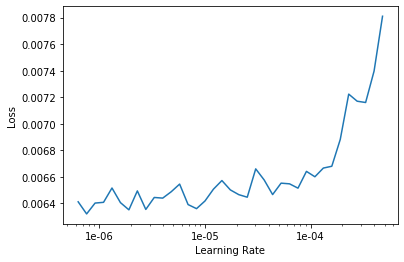

In [29]:
lr_find(imagenetTransferLearn)
imagenetTransferLearn.recorder.plot()

In [30]:
lr=1e-5
imagenetTransferLearn.fit_one_cycle(10,lr)
imagenetTransferLearn.save('imagenetTransferLearn-unfrozen-10')

epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.006651,0.008831,0.996482,0.911200,0.905282,0.790555,11:32
1,0.007014,0.008896,0.996476,0.910292,0.905171,0.790287,11:32
2,0.006802,0.009524,0.996446,0.912656,0.907462,0.793782,11:31
3,0.006393,0.008786,0.996494,0.909043,0.903428,0.788306,11:31
4,0.006251,0.008904,0.996498,0.911607,0.908979,0.790379,11:32
5,0.006415,0.008760,0.996491,0.908596,0.906856,0.786488,11:32
6,0.006032,0.008872,0.996489,0.907936,0.905701,0.787483,11:32
7,0.006520,0.008550,0.996525,0.904257,0.905720,0.783376,11:31
8,0.006018,0.008796,0.996491,0.908526,0.905026,0.790259,11:32
9,0.006176,0.008650,0.996519,0.909757,0.906930,0.790860,11:31


In [31]:
imagenetTransferLearn.export('imagenetTransferLearn.pkl',destroy=True)

this Learner object self-destroyed - it still exists, but no longer usable


In [32]:
tmp = make_full_predictions('imagenetTransferLearn.pkl', 'imagenetTransferLearn')

## Base Network (no fine tuning)

In [33]:
baseModel = load_learner("resnet34_5percent_size256_extremeTfms_ceLoss", 'model.pkl')

In [34]:
baseModel.data = data

In [35]:
baseModel.validate()

[0.034869652, tensor(0.9928), tensor(0.7905), tensor(0.7818), tensor(0.6175)]

In [84]:
tmp = make_full_predictions('../resnet34_5percent_size256_extremeTfms_ceLoss/model.pkl', 'baseModel')

## Double Transfer Learning (imagenet, kaggle)

In [36]:
baseModel.path = Path('images')

In [37]:
baseModel.callback_fns[1]=partial(CSVLogger, append=True, filename="doubleTransferLearn_log")

In [38]:
baseModel.freeze_to(-1)

In [39]:
lr_find(baseModel)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


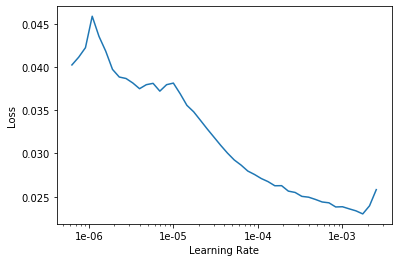

In [40]:
baseModel.recorder.plot()

In [41]:
lr=1e-4
baseModel.fit_one_cycle(10, lr)
baseModel.save('doubleTransferLearn-frozen-10')

epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.007869,0.009214,0.996377,0.901400,0.900145,0.775032,11:36
1,0.008402,0.010386,0.996106,0.879296,0.883206,0.757463,11:31
2,0.008025,0.010130,0.996113,0.900770,0.902134,0.777490,11:29
3,0.008450,0.008521,0.996530,0.896190,0.890950,0.781136,11:30
4,0.006907,0.007937,0.996745,0.907021,0.899561,0.788257,11:28
5,0.007194,0.008467,0.996498,0.918163,0.911652,0.800385,11:26
6,0.006471,0.008008,0.996848,0.918863,0.916224,0.802137,11:30
7,0.006673,0.008360,0.996556,0.913643,0.907760,0.798934,11:27
8,0.005595,0.007782,0.996848,0.923980,0.918291,0.810194,11:28
9,0.005945,0.007688,0.996926,0.922831,0.918815,0.810068,11:27


In [42]:
baseModel.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


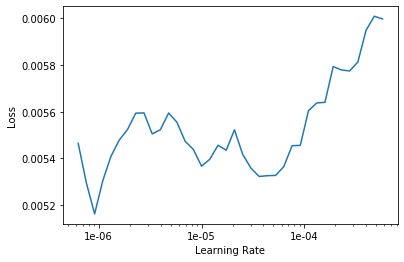

In [43]:
lr_find(baseModel)
baseModel.recorder.plot()

In [44]:
lr=1e-5
baseModel.fit_one_cycle(10, lr)
baseModel.save('doubleTransferLearn-unfrozen-10')

epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.005871,0.007871,0.996858,0.923112,0.918225,0.809736,11:27
1,0.005883,0.007748,0.996883,0.920139,0.917609,0.807764,11:27
2,0.005411,0.008078,0.996795,0.925098,0.917812,0.812195,11:27
3,0.005890,0.007716,0.996913,0.923392,0.918395,0.808990,11:26
4,0.005842,0.008066,0.996846,0.921521,0.915359,0.808071,11:29
5,0.005608,0.008116,0.996800,0.919679,0.913280,0.806449,11:28
6,0.005564,0.007956,0.996837,0.920773,0.915266,0.807630,11:28
7,0.006178,0.008065,0.996814,0.927163,0.919669,0.812511,11:27
8,0.005860,0.008109,0.996810,0.926271,0.918609,0.812520,11:28
9,0.005474,0.008224,0.996792,0.923654,0.917240,0.810058,11:28


In [45]:
baseModel.export('doubleTransferLearn.pkl',destroy=True)

this Learner object self-destroyed - it still exists, but no longer usable


In [46]:
tmp = make_full_predictions('doubleTransferLearn.pkl', 'doubleTransferLearn')